# Try to use OCR to recognize the letters in the Wordle game

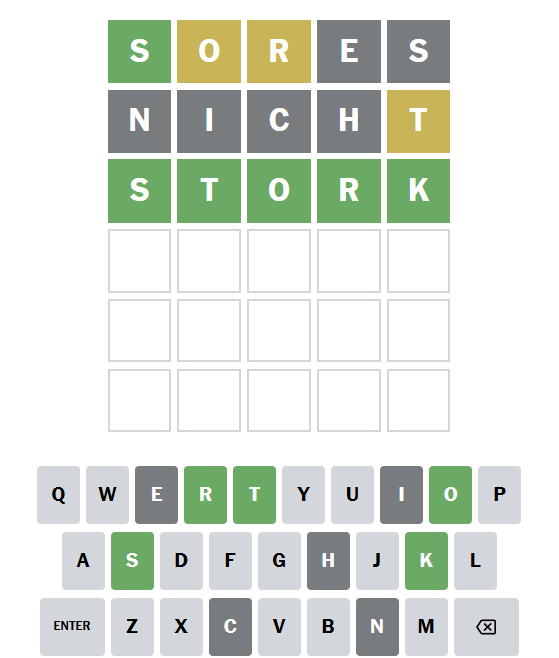

In [1]:
# Load test image
from IPython.display import Image, display

# Show the image
display(Image(filename='images/solved.PNG'))

In [2]:
from image_processing import get_wordle_grid_boxes, crop_cell_margin, detect_letter, tesseract_inference
import cv2

image = cv2.imread('images/solved.PNG')

rows = get_wordle_grid_boxes(image)

if rows:
    print(f"Extracted {len(rows)} rows from the Wordle board")

    # Crop the cells and put them into a nested list
    wordle_board_imgs = []
    for row in rows:
        wordle_board_row = []
        for cell in row:
            x, y, w, h = cell[1:5]
            cropped_cell = image[y:y+h, x:x+w]
            cropped_cell = crop_cell_margin(cropped_cell)
            wordle_board_row.append(cropped_cell)
        wordle_board_imgs.append(wordle_board_row)


    # Run Tesseract OCR on each cell
    for i, row in enumerate(wordle_board_imgs):
        for j, cell in enumerate(row):
            if detect_letter(cell.copy()):
                # Show the thresholded image
                cv2.imshow("Croped Image", cell)
                cv2.waitKey(0)
                cv2.destroyAllWindows()


                letter = tesseract_inference(cell)
                print(f"Row {i+1}, Column {j+1}: {letter}")
            else:
                print(f"Row {i+1}, Column {j+1}: No letter detected")
else:
    print(f"Failed to extract wordle board, found {len(rows)} rows instead of 6")

Extracted 6 rows from the Wordle board
Row 1, Column 1: S
Row 1, Column 2: None
Row 1, Column 3: R
Row 1, Column 4: E
Row 1, Column 5: S
Row 2, Column 1: N
Row 2, Column 2: None
Row 2, Column 3: C
Row 2, Column 4: H
Row 2, Column 5: T
Row 3, Column 1: S
Row 3, Column 2: T
Row 3, Column 3: None
Row 3, Column 4: R
Row 3, Column 5: K
Row 4, Column 1: No letter detected
Row 4, Column 2: No letter detected
Row 4, Column 3: No letter detected
Row 4, Column 4: No letter detected
Row 4, Column 5: No letter detected
Row 5, Column 1: No letter detected
Row 5, Column 2: No letter detected
Row 5, Column 3: No letter detected
Row 5, Column 4: No letter detected
Row 5, Column 5: No letter detected
Row 6, Column 1: No letter detected
Row 6, Column 2: No letter detected
Row 6, Column 3: No letter detected
Row 6, Column 4: No letter detected
Row 6, Column 5: No letter detected


# Also extract the colors from the Wordle board

In [1]:
from image_processing import get_wordle_grid_boxes, crop_cell_margin, detect_letter, extract_color_from_cell
import cv2

image = cv2.imread('images/row 2.PNG')

rows = get_wordle_grid_boxes(image)

if rows:
    print(f"Extracted {len(rows)} rows from the Wordle board")

    # Crop the cells and put them into a nested list
    wordle_board_imgs = []
    for row in rows:
        wordle_board_row = []
        for cell in row:
            x, y, w, h = cell[1:5]
            cropped_cell = image[y:y+h, x:x+w]
            cropped_cell = crop_cell_margin(cropped_cell)
            wordle_board_row.append(cropped_cell)
        wordle_board_imgs.append(wordle_board_row)


    # Run Tesseract OCR on each cell
    for i, row in enumerate(wordle_board_imgs):
        for j, cell in enumerate(row):
            if detect_letter(cell.copy()):
                # Show the thresholded image
                cv2.imshow("Croped Image", cell)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

                color = extract_color_from_cell(cell)
                print(f"Row {i+1}, Column {j+1}: {color}")
            else:
                print(f"Row {i+1}, Column {j+1}: No letter detected")
else:
    print(f"Failed to extract wordle board, found {len(rows)} rows instead of 6")

Extracted 6 rows from the Wordle board
Row 1, Column 1: 1
Row 1, Column 2: 0
Row 1, Column 3: 2
Row 1, Column 4: 2
Row 1, Column 5: 2
Row 2, Column 1: 2
Row 2, Column 2: 0
Row 2, Column 3: 1
Row 2, Column 4: 2
Row 2, Column 5: 2
Row 3, Column 1: No letter detected
Row 3, Column 2: No letter detected
Row 3, Column 3: No letter detected
Row 3, Column 4: No letter detected
Row 3, Column 5: No letter detected
Row 4, Column 1: No letter detected
Row 4, Column 2: No letter detected
Row 4, Column 3: No letter detected
Row 4, Column 4: No letter detected
Row 4, Column 5: No letter detected
Row 5, Column 1: No letter detected
Row 5, Column 2: No letter detected
Row 5, Column 3: No letter detected
Row 5, Column 4: No letter detected
Row 5, Column 5: No letter detected
Row 6, Column 1: No letter detected
Row 6, Column 2: No letter detected
Row 6, Column 3: No letter detected
Row 6, Column 4: No letter detected
Row 6, Column 5: No letter detected


# Try CNN letter recognition
- When the background is white, need to invert, as CNN is trained on black background white letters
- White background is only possible when cell is not final, and since we no need to recognize the letter, we can just skip those
- Will be implemented in solve_wordle.py

In [5]:
from image_processing import get_wordle_grid_boxes, crop_cell_margin, detect_letter
from alphabet_classifier.helper_functions import MNISTClassifier, wordle_cell_preprocessing, transform_handwritten_alphabet_dataset
import cv2
import torch
from PIL import Image

# load pytorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassifier().to(device)
state_dict = torch.load("alphabet_classifier/models/finetune_model_100.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

image = cv2.imread('images/row 1.PNG')

rows = get_wordle_grid_boxes(image)

if rows:
    print(f"Extracted {len(rows)} rows from the Wordle board")

    # Crop the cells and put them into a nested list
    wordle_board_imgs = []
    for row in rows:
        wordle_board_row = []
        for cell in row:
            x, y, w, h = cell[1:5]
            cropped_cell = image[y:y+h, x:x+w]
            cropped_cell = crop_cell_margin(cropped_cell)
            wordle_board_row.append(cropped_cell)
        wordle_board_imgs.append(wordle_board_row)


    # Run CNN model on each cell
    for i, row in enumerate(wordle_board_imgs):
        for j, cell in enumerate(row):
            if detect_letter(cell.copy()):
                # Pytorch model inference
                # Convert image to binary thresholded image
                thresh = wordle_cell_preprocessing(cell.copy())

                # Check if background is white or grey
                # CNN is trained on black background white letters
                # So need to invert the image if background is white or grey
                mean_pixel_value = cv2.mean(thresh)[0]
                if mean_pixel_value > 127:
                    thresh = cv2.bitwise_not(thresh)

                # Show
                cv2.imshow("Croped Image", thresh)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

                alphabet = Image.fromarray(thresh)

                # Convert to tensor and apply transformations
                alphabet_tensor = transform_handwritten_alphabet_dataset()(alphabet)
                # Add batch dimension
                alphabet_tensor = alphabet_tensor.unsqueeze(0).to(device)

                # Inference
                with torch.no_grad():
                    logits = model(alphabet_tensor)
                    pred = logits.argmax(dim=1).item()
                    letter = chr(ord('A') + pred)

                    # Get confidence
                    confidence = torch.max(torch.softmax(logits, dim=1)).item()
                print(f"Row {i+1}, Column {j+1}: {letter}, Confidence: {confidence:.2f}")
            else:
                print(f"Row {i+1}, Column {j+1}: No letter detected")
else:
    print(f"Failed to extract wordle board, found {len(rows)} rows instead of 6")

Extracted 6 rows from the Wordle board
Row 1, Column 1: H, Confidence: 1.00
Row 1, Column 2: V, Confidence: 1.00
Row 1, Column 3: I, Confidence: 0.62
Row 1, Column 4: D, Confidence: 1.00
Row 1, Column 5: A, Confidence: 1.00
Row 2, Column 1: No letter detected
Row 2, Column 2: No letter detected
Row 2, Column 3: No letter detected
Row 2, Column 4: No letter detected
Row 2, Column 5: No letter detected
Row 3, Column 1: No letter detected
Row 3, Column 2: No letter detected
Row 3, Column 3: No letter detected
Row 3, Column 4: No letter detected
Row 3, Column 5: No letter detected
Row 4, Column 1: No letter detected
Row 4, Column 2: No letter detected
Row 4, Column 3: No letter detected
Row 4, Column 4: No letter detected
Row 4, Column 5: No letter detected
Row 5, Column 1: No letter detected
Row 5, Column 2: No letter detected
Row 5, Column 3: No letter detected
Row 5, Column 4: No letter detected
Row 5, Column 5: No letter detected
Row 6, Column 1: No letter detected
Row 6, Column 2: No 